# Aufgabe 41: Entfaltung mit quadratischen Matrizen

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# matplotlib Einstellungen
%config InlineBackend.figure_formats = ['svg','png']
import matplotlib as mpl
mpl.rcParams['font.size'] = 13
mpl.rcParams['figure.figsize'] = (7,5)
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

In [3]:
rng = np.random.default_rng(seed=42)

In [4]:
np.set_printoptions(linewidth=200)

## a) Antwortmatrix erzeugen

### Theorie:

$$
A = 
\begin{pmatrix}
    1-\epsilon & \epsilon & 0 & ... & 0 \\
    \epsilon & 1-2\epsilon & \epsilon & ... & 0 \\
    0 & \epsilon & 1-2\epsilon & ... & 0 \\
    ... & ... & ... & ... & ... \\
    0 & ... & ... & 1-2\epsilon & \epsilon \\
    0 & ... & ... & \epsilon & 1-\epsilon \\
\end{pmatrix}
$$

Was für einen Messprozess beschreibt die Matrix A?  
$\vec{g} = A \vec{f}$, wobei  
- $\vec{f} \hat{=}$ Verteilung der "wahren" Werte $\vec{y}$ des physikalischen Prozesses
- $\vec{g} \hat{=}$ Verteilung der gemessenen Werte $\vec{x}$ des physikalischen Prozesses
- $f_j, g_i$ sind absolute oder relative Anzahlen bzw. Wahrscheinlichkeiten
- $y_j$ sind die gebinnten Abhängigkeiten der Theorie (z.B. Energie, Masse, Impuls, ...)
- $x_i$ sind die gebinnten direkt gemessenen Werte (Ladungen, Orte, Zeiten)

Für den Spezialfall dieser Matrix:
- $n \times n \Rightarrow$ Genau gleich viele Bins in $y$ und $x$
- fast diagonal $\Rightarrow$ Verschmierung der Messung, aber nur in Nachbar-Bins mit Wahrscheinlichkeit $\epsilon$

### Implementierung:

Es sei $\epsilon = 0.23$ und $n \geq 3$

In [5]:
def buildA(n, epsilon = 0.23):
    # main diagonal
    main_diag = np.ones(shape=(n,))
    main_diag[[0,-1]] -= epsilon
    main_diag[1:-1] -= 2*epsilon
    
    # second diagonal
    second_diag = epsilon * np.ones(shape=(n-1,))
    
    # insert into the matrix
    A = np.diag(main_diag, k=0)
    A += np.diag(second_diag, k=1)
    A += np.diag(second_diag, k=-1)
    
    return A

In [6]:
# Example:
buildA(5)

array([[0.77, 0.23, 0.  , 0.  , 0.  ],
       [0.23, 0.54, 0.23, 0.  , 0.  ],
       [0.  , 0.23, 0.54, 0.23, 0.  ],
       [0.  , 0.  , 0.23, 0.54, 0.23],
       [0.  , 0.  , 0.  , 0.23, 0.77]])

## b) Monte Carlo Simulation der Messung  

$\vec{f} = (193, 485, 664, 763, 804, 805, 779, 736, 684, 626, 566, 508, 452, 400, 351, 308, 268, 233, 202, 173)^T$  
wobei $\vec{y}$ im Intervall $[0,2]$ gleichmäßig gebinnt ist.

$\vec{\lambda} = A \vec{f}$ seien die Erwartungswerte der Messung.  
Außerdem sei jeder Bin $i$ von $\vec{x}$ Poisson-verteilt mit Erwartungswert $\lambda_i$.  
$\Rightarrow$ Simuliere die Messerwerte $\vec{g}$ durch Ziehung aus den Poisson-Verteilungen.  
$\Rightarrow$ Die Varianz von $\vec{g}$ ist $Var[\vec{g}] = \vec{\lambda}$

In [7]:
def simulate_g(f, A, rng):
    lam = A @ f
    g = rng.poisson(lam)
    return g, lam

In [8]:
f_true = np.array([193, 485, 664, 763, 804, 805, 779, 736, 684, 626,
              566, 508, 452, 400, 351, 308, 268, 233, 202, 173])

y_bins = np.linspace(0, 2, len(f_true)+1)
y_diffs = np.diff(y_bins)
y_centers = y_bins[:-1] + y_diffs/2

In [9]:
f_true.shape, y_bins.shape, y_centers.shape

((20,), (21,), (20,))

In [10]:
# simulate g
A = buildA(20)
 
g_sim, lam = simulate_g(f_true, A, rng)
print(f'lambda = {lam}')
print(f'g_sim = {g_sim}')

x_bins = np.linspace(0, 1, len(g_sim)+1)
x_centers = x_bins[:-1] + np.diff(x_bins)/2

lambda = [260.16 459.01 645.6  749.66 794.8  798.79 775.09 733.93 682.62 625.54 566.46 508.46 452.92 400.69 352.38 308.69 269.15 233.92 202.46 179.67]
g_sim = [274 485 606 772 758 788 787 730 687 652 585 528 451 377 343 307 248 221 200 188]


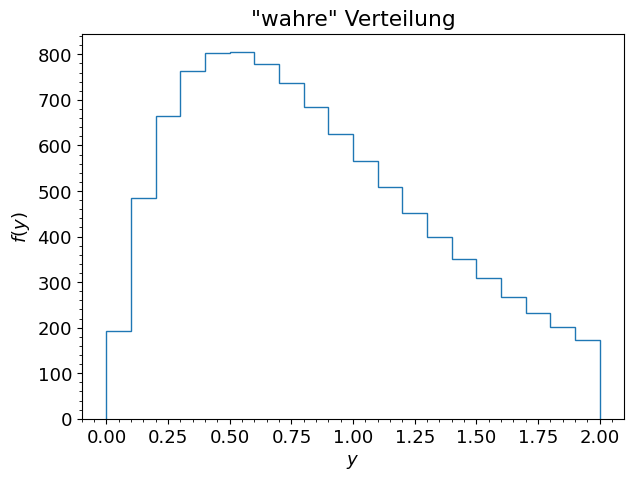

In [11]:
# Plot the ground truth
plt.title('"wahre" Verteilung')
plt.hist(y_centers, bins=y_bins, weights=f_true, histtype='step')
plt.xlabel('$y$')
plt.ylabel('$f(y)$')
plt.show()

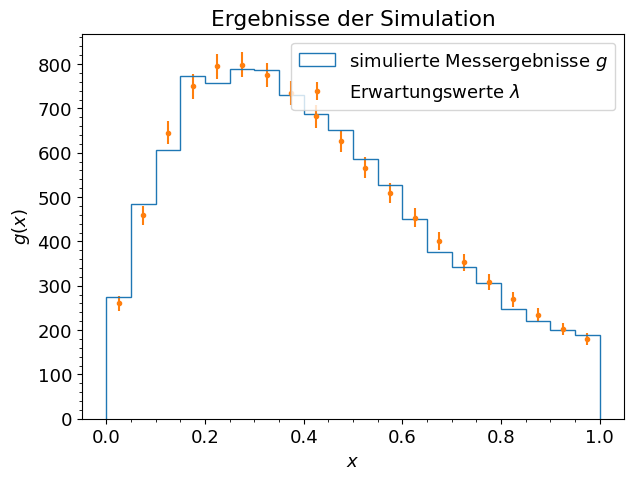

In [12]:
# Plot the simulated results
plt.title('Ergebnisse der Simulation')
plt.hist(x_centers, bins=x_bins, weights=g_sim, histtype='step', label='simulierte Messergebnisse $g$')
plt.errorbar(x_centers, lam, np.sqrt(lam), fmt='.', label='Erwartungswerte $\lambda$')
plt.xlabel('$x$')
plt.ylabel('$g(x)$')

plt.legend(loc='upper right')
plt.show()

## c) Diagonalisiere die Faltung

Diagonalisiere $A$ über $A = U D U^{-1}$, wobei $D$ diagonal ist.  
Dafür bestimme die Eigenwerte $\omega_i$ von $A$ und schreibe sie auf die Diagonale von $D$  
und bestimme die Eigenvektoren $\vec{u}_i$ von $A$ und schreibe sie in die Spalten von $U$.

Damit wird $\vec{g} = A \vec{f}$ zu $U^{-1} \vec{g} = D U^{-1} \vec{f}$.  
Definiere nun $\vec{c} = U^{-1} \vec{g}$ und $\vec{b} = U^{-1} \vec{f}$.  

Vorteil dieser Darstellung ist, dass $c_j, b_j$ unabhängig transformiert werden.  
$\Rightarrow c_j = \omega_j \cdot b_j$  
$\Leftrightarrow b_j = c_j \,/\, \omega_j$

In [13]:
# Calculate the eigenvalues and eigenvectors of A
w, v = np.linalg.eig(A)

print(f'w.shape = {w.shape}')
print(f'v.shape = {v.shape}')

w.shape = (20,)
v.shape = (20, 20)


In [14]:
# sort the eigenvalues and eigenvectors descending
sorted_idx = np.argsort(w) # is sorted ascending
sorted_idx = np.flip(sorted_idx) # is sorted descending
with np.printoptions(precision=3):
    print(f'omega_unsorted = {w}')
    print(f'omega_sorted   = {w[sorted_idx]}')

omega_unsorted = [0.086 0.103 0.13  0.168 0.215 0.27  0.331 0.398 0.468 0.54  0.612 0.682 0.749 0.81  0.865 1.    0.994 0.977 0.95  0.912]
omega_sorted   = [1.    0.994 0.977 0.95  0.912 0.865 0.81  0.749 0.682 0.612 0.54  0.468 0.398 0.331 0.27  0.215 0.168 0.13  0.103 0.086]


In [15]:
# create the matrices D and U
D = np.diag(w[sorted_idx])
U = v[:,sorted_idx]

# invert D and U
D_inv = np.linalg.inv(D)
U_inv = np.linalg.inv(U)

## d) Transformiere $\vec{f} \rightarrow \vec{b}$ und $\vec{g} \rightarrow \vec{c}$

$\vec{c} = U^{-1} \vec{g}$ und $\vec{b} = U^{-1} \vec{f}$  

Kovarianzmatrix über die "BVB-Formel" der Fehlerfortpflanzung (die Variablen haben nichts mit der Aufgabe zu tun):  
Lineare Transformation: $\vec{y} = B \vec{x}$  
Kovarianzmatrix: $Var[\vec{y}] = B \cdot Var[\vec{x}] \cdot B^T$

In [16]:
# calculate the transformed distributions
b_true = U_inv @ f_true

b_sim = D_inv @ U_inv @ g_sim

In [17]:
# calculate the covariance matrix
Cov_g_sim = np.diag(lam)

Cov_b_sim = (D_inv @ U_inv) @ Cov_g_sim @ (D_inv @ U_inv).T
Var_b_sim = np.diag(Cov_b_sim)

In [18]:
with np.printoptions(precision=2):
    print(f'b_true = {b_true}')
    print(f'b_sim  = {b_sim}')

b_true = [-2236.07  -676.69  -488.77  -333.32  -275.06  -169.02  -140.1    -92.29    80.09   -54.83    49.64   -35.52   -32.42   -22.39   -20.85    14.22    12.89     8.15    -5.47    -2.91]
b_sim  = [-2233.16  -687.15  -505.88  -330.89  -221.74  -161.79  -136.94   -84.12    55.12   -82.02    41.82    -9.29   -17.51    35.72   -49.73   161.65   174.09   234.49  -209.21  -192.28]


In [19]:
b_norm = np.abs(b_sim/np.sqrt(Var_b_sim))

with np.printoptions(precision=2):
    print(f'b_norm = {b_norm}')

b_norm = [99.87 33.16 23.05 14.32  9.12  6.29  4.97  2.82  1.68  2.24  1.01  0.19  0.31  0.53  0.6   1.55  1.3   1.34  0.92  0.69]


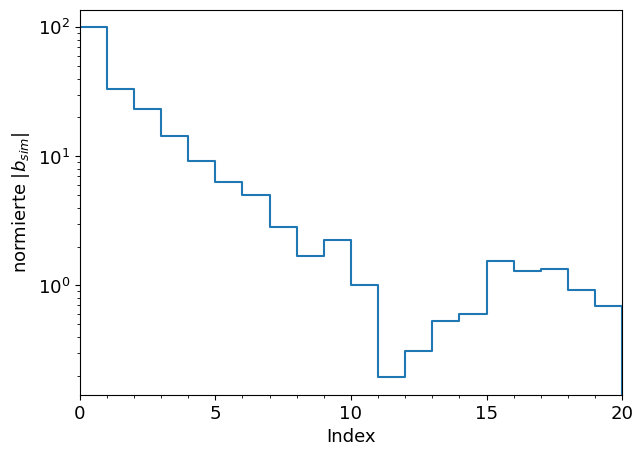

In [20]:
# plot the transformed distributions
plt.step(np.arange(len(b_norm)+1),np.append(b_norm,0), where='post')
plt.yscale('log')
plt.xticks(np.arange(0,21,5))
plt.xlim(0,20)
plt.xlabel('Index')
plt.ylabel(r'normierte $|b_{sim}|$')
plt.show()

## e) Regularisieren und Entfalten

$\vec{f} = U \vec{b}$

In [21]:
# unfolding with regularization
cutoff_idxs = [20,11]

f_reg = []
Cov_f_reg = []
Var_f_reg = []

for cutoff_idx in cutoff_idxs:
    U_reg = U[:,:cutoff_idx]
    b_reg = b_sim[:cutoff_idx]
    Cov_b_sim_reg = Cov_b_sim[:cutoff_idx,:cutoff_idx]
    
    f_reg.append( U_reg @ b_reg )
    Cov_f_reg.append( U_reg @ Cov_b_sim_reg @ U_reg.T)
    Var_f_reg.append( np.diag(Cov_f_reg[-1]) )

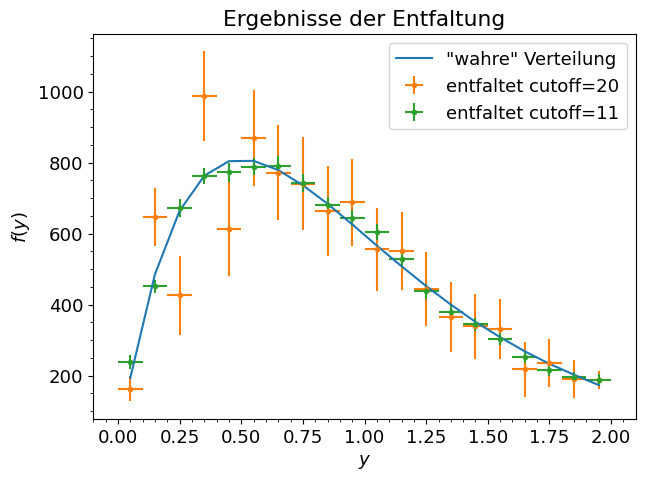

In [22]:
# plot the resulting distributions
plt.title('Ergebnisse der Entfaltung')

plt.plot(y_centers, f_true, '-', label='"wahre" Verteilung')

for f_sim, Var_f_sim, cutoff_idx in zip(f_reg, Var_f_reg, cutoff_idxs):
    plt.errorbar(y_centers, f_sim, yerr=np.sqrt(Var_f_sim), xerr=y_diffs/2, fmt='.', label=f'entfaltet cutoff={cutoff_idx}')

plt.xlabel('$y$')
plt.ylabel('$f(y)$')
plt.legend()
plt.show()